### 아마존 리뷰 데이터를 사용한 텍스트 요약 모델 만들기
- 자연어 전처리 없이 모델을 훈련한 코드

In [1]:
# !pip install evaluate rouge_score absl-py

In [2]:
import pandas as pd
import re
import contractions
import numpy as np

In [3]:
### 데이터 로드
filename = '../data/Books_ratings_100k.csv'
reviewDF = pd.read_csv(filename)

In [4]:
### 데이터 확인 (결측치 없음)
reviewDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review/summary  100000 non-null  object
 1   review/text     100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [5]:
### 데이터 확인 (랜덤으로 샘플 10개씩 추출)
reviewDF.sample(10)

,review/summary,review/text
80492,defies common sense,This book is boring and idiotic.Only a fool wo...
57393,Austen's nosensical girl Emma expertly read by...,"EMMA, Jane Austen's fourth novel was published..."
94651,Review for Great Expectations,I thought this book was a really good book. I ...
59083,good purchasing,have received the book some days ago. conditio...
86488,A wonderful collection of unique recipes for b...,This is a great variety of breads with easy to...
59033,Beyond a Novel,It is a mistake to try to read this book along...
36141,Looking forward to more movies from this series,"Saw John Carter and loved it. Good story, acti..."
55030,A fun book,This is a fun book and it espacially helps you...
91458,Self-Esteem 101,This should be a required course in high schoo...
92159,Felt the Holy Spirit coming through the pages.,The first part of this book is sometimes scary...


In [6]:
### frac : 전체 데이터 중 얼마나 사용할 것인지 (나는 0.1에 해당하는 1만 개만 사용)
### 60%, 20%, 20% 로 데이터 분할
train, valid, test = np.split(
    reviewDF.sample(frac=0.1, random_state=42), [int(0.06 * len(reviewDF)), int(0.08 * len(reviewDF))]
)

In [7]:
len(train), len(valid), len(test)

(6000, 2000, 2000)

In [8]:
### 텍스트 소문자화
sentence = 'I LOVED IT'
sentence.lower()

'i loved it'

In [9]:
### 소괄호로 둘러싸인 문자열 삭제
pattern = r'\([^)]*\)'
sentence = 'my husband (and myself) for'
re.sub(pattern, '', sentence)

'my husband  for'

In [10]:
### 대괄호로 둘러싸인 문자열 삭제
pattern = r'\[[^\]]*\]'
sentence = 'my husband [and myself] for'
re.sub(pattern, '', sentence)

'my husband  for'

In [11]:
### 344개 조합 (축약어, 슬랭)
len(contractions.contractions_dict.keys())

344

In [12]:
contractions.fix("I've known that.")

'I have known that.'

In [13]:
import torch
from transformers import BartTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

c:\Users\DELL-PC\miniconda3\envs\Text_017_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def make_dataset(data, tokenizer, device):
    tokenized = tokenizer(  # tokenized : transformers.tokenization_utils_base.BatchEncoding
        text=data['review/text'].tolist(),  # data 안의 text를 list로 변환
        padding="longest",                  # 가장 긴 시퀀스의 길이에 맞춰 패딩을 추가
        truncation=True,                    # 입력 데이터가 모델의 최대입력길이를 초과하는 경우 자르는 작업
        return_tensors="pt",                # 토큰화된 결과를 pytorch tensor로 반환
        max_length=256                      # transformers 4.37.2 에서는 없어도 자동으로 길이고정됨. transformers 4.40.0 에서는 max_length를 줘야 고정됨
    )   # tokenized : 'input_ids', 'attention_mask' 로 구성 (둘 다 tensor이고, shape : [3000, 3913])
    labels = []
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    for target in data['review/summary']:
        ### 요약 문자열을 토큰화, 정수화 하여 텐서로 저장
        labels.append(tokenizer.encode(target, return_tensors="pt").squeeze())
    ### 입력으로 주어진 시퀀스 중 가장 긴 길이에 맞춰서 패딩을 수행한다. (shape : [30])
    labels = pad_sequence(labels, batch_first=True, padding_value=-100).to(device)
    return TensorDataset(input_ids, attention_mask, labels)

def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader

In [15]:
### 에폭, 배치사이즈, 디바이스, 토크나이저
epochs = 100
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BartTokenizer.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
)

In [16]:
type(tokenizer)

transformers.models.bart.tokenization_bart.BartTokenizer

In [17]:
train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(train_dataset[0])

(tensor([    0,  2747,   534, 31901,   725,   328,   387, 12807,    42,  1040,
           25,    38,   115,    45,  2067,    13,     5,  1569,     7,    28,
          703,     4,    38,  2333,   109,    45,   101,  4133,   156,    31,
         2799,   734, 32259, 11737,  2520,  8302,  1569,    21,    10,  6906,
           13,  4327,     4, 10462,     6,   143, 19721,     6,  3049,    50,
           45,     6,    16,   357,    87,    42,  1040,     4,   243,   362,
          162,    81,   727,  6052,     7,   120,   341,     7,  9786,    18,
        13430,     6,  2982,   267, 26427,     6,     8,   475, 23521,  2496,
            4,    38,   888,    21,  2008,     9,  2185,  2053,    38,   218,
           75,  1166,   615,    31,  2182,  7601,     4,  1308,  1623, 17261,
          162,     8,    26,    60,  8987,   213,   356,    23,   110,  2799,
          700, 13491,    72,    38,   115,    45,  1413,    69,  2410,  2496,
            4,   264,    16,    45,    10, 26669,   868,  2048,

In [18]:
x, y, z = train_dataset[0]
print(x.shape)  
print(y.shape)
print(z.shape)

torch.Size([256])
torch.Size([256])
torch.Size([37])


In [19]:
x, y, z = valid_dataset[0]
print(x.shape)
print(y.shape)
print(z.shape)

torch.Size([256])
torch.Size([256])
torch.Size([41])


In [20]:
x, y, z = test_dataset[0]
print(x.shape)
print(y.shape)
print(z.shape)

torch.Size([256])
torch.Size([256])
torch.Size([31])


In [21]:
from torch import optim
from transformers import BartForConditionalGeneration


model = BartForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)

In [22]:
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

model
└ shared
└ encoder
│  └ embed_tokens
│  └ embed_positions
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  └ layernorm_embedding
└ decoder
│  └ embed_tokens
│  └ embed_positions
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  └ layernorm_embedding
lm_head


In [23]:
import numpy as np
import evaluate
import rouge_score

In [24]:
def calc_rouge(preds, labels):
    preds = preds.argmax(axis=-1)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge2 = rouge_score.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )
    return rouge2["rouge2"]

In [25]:
def train(model, optimizer, dataloader):
    model.train()
    train_loss, train_rouge = 0.0, 0.0

    for input_ids, attention_mask, labels in dataloader:
        # print(f'input_ids => {input_ids.shape}')
        # print(f'attention_mask => {attention_mask.shape}')
        # print(f'labels => {labels.shape}')
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to("cpu").numpy()
        rouge = calc_rouge(logits, label_ids)
        
        train_loss += loss.item()
        train_rouge += rouge
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    train_rouge = train_rouge / len(dataloader)
    return train_loss, train_rouge

In [26]:
def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss, val_rouge = 0.0, 0.0

        for input_ids, attention_mask, labels in dataloader:
            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )
            logits = outputs.logits
            loss = outputs.loss

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            rouge = calc_rouge(logits, label_ids)
            
            val_loss += loss
            val_rouge += rouge

    val_loss = val_loss / len(dataloader)
    val_rouge = val_rouge / len(dataloader)
    return val_loss, val_rouge

In [27]:
from tqdm import tqdm

In [28]:
epoch_logs_path = '../models/progress.txt'
train_list, val_list = [[], []], [[], []]   ## 각각 loss, accuracy 저장

rouge_score = evaluate.load("rouge", tokenizer=tokenizer)
best_loss, best_epoch = 10000, 0
for epoch in tqdm(range(epochs)):
    train_metrics = train(model, optimizer, train_dataloader)
    val_metrics = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_metrics[0]:.4f} Val Loss: {val_metrics[0]:.4f} Val Rouge {val_metrics[1]:.4f}")

    for i in range(2):
        train_list[i].append(train_metrics[i])
        val_list[i].append(val_metrics[i].to("cpu").numpy())
    
    if val_metrics[0] < best_loss:
        ### val_loss가 best_loss보다 개선되면 저장
        best_loss = val_metrics[0]
        best_epoch = epoch
        torch.save(model.state_dict(), "../models/Best_Bart_Amazon_Books.pt")
        # print("Saved the model weights")
    
    ### 가장 많은 Epoch을 돌린 모델 저장
    torch.save(model.state_dict(), "../models/Latest_Bart_Amazon_Books.pt")

    ### 최신 진행정보 저장
    with open(epoch_logs_path, 'w') as file:
        file.write(str(f'Epoch {epoch} Completed\nBest Epoch : {best_epoch}'))

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\DELL-PC\miniconda3\envs\Text_017_38\lib\site-packages\transformers\models\bart\modeling_bart.py:590: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1: Train Loss: 3.4604 Val Loss: 3.0373 Val Rouge 0.0975


  1%|          | 1/100 [01:35<2:37:02, 95.18s/it]

Epoch 2: Train Loss: 2.9356 Val Loss: 3.0412 Val Rouge 0.0946


  2%|▏         | 2/100 [03:05<2:30:48, 92.33s/it]

Epoch 3: Train Loss: 2.5859 Val Loss: 3.0973 Val Rouge 0.0945


  3%|▎         | 3/100 [04:34<2:26:41, 90.73s/it]

Epoch 4: Train Loss: 2.2962 Val Loss: 3.1904 Val Rouge 0.0906


  4%|▍         | 4/100 [06:03<2:24:20, 90.21s/it]

Epoch 5: Train Loss: 1.9915 Val Loss: 3.2954 Val Rouge 0.0845


  5%|▌         | 5/100 [07:32<2:22:11, 89.80s/it]

Epoch 6: Train Loss: 1.7181 Val Loss: 3.4348 Val Rouge 0.0793


  6%|▌         | 6/100 [09:02<2:20:26, 89.64s/it]

Epoch 7: Train Loss: 1.4520 Val Loss: 3.6089 Val Rouge 0.0632


  7%|▋         | 7/100 [10:31<2:18:53, 89.60s/it]

Epoch 8: Train Loss: 1.2168 Val Loss: 3.7950 Val Rouge 0.0752


  8%|▊         | 8/100 [12:00<2:17:14, 89.50s/it]

Epoch 9: Train Loss: 1.0011 Val Loss: 3.9267 Val Rouge 0.0732


  9%|▉         | 9/100 [13:30<2:15:32, 89.36s/it]

Epoch 10: Train Loss: 0.8220 Val Loss: 4.0596 Val Rouge 0.0783


 10%|█         | 10/100 [14:59<2:13:57, 89.31s/it]

Epoch 11: Train Loss: 0.6552 Val Loss: 4.1969 Val Rouge 0.0757


 11%|█         | 11/100 [16:28<2:12:27, 89.30s/it]

Epoch 12: Train Loss: 0.5208 Val Loss: 4.2864 Val Rouge 0.0696


 12%|█▏        | 12/100 [17:58<2:11:11, 89.44s/it]

Epoch 13: Train Loss: 0.4368 Val Loss: 4.4124 Val Rouge 0.0804


 13%|█▎        | 13/100 [19:27<2:09:30, 89.31s/it]

Epoch 14: Train Loss: 0.3385 Val Loss: 4.5076 Val Rouge 0.0824


 14%|█▍        | 14/100 [20:55<2:07:44, 89.12s/it]

Epoch 15: Train Loss: 0.2731 Val Loss: 4.5508 Val Rouge 0.0725


 15%|█▌        | 15/100 [22:25<2:06:30, 89.30s/it]

Epoch 16: Train Loss: 0.2250 Val Loss: 4.6262 Val Rouge 0.0829


 16%|█▌        | 16/100 [23:55<2:05:17, 89.50s/it]

Epoch 17: Train Loss: 0.1925 Val Loss: 4.6736 Val Rouge 0.0719


 17%|█▋        | 17/100 [25:24<2:03:43, 89.44s/it]

Epoch 18: Train Loss: 0.1595 Val Loss: 4.7225 Val Rouge 0.0717


 18%|█▊        | 18/100 [26:54<2:02:24, 89.57s/it]

Epoch 19: Train Loss: 0.1407 Val Loss: 4.8324 Val Rouge 0.0719


 19%|█▉        | 19/100 [28:24<2:00:57, 89.60s/it]

Epoch 20: Train Loss: 0.1256 Val Loss: 4.8586 Val Rouge 0.0809


 20%|██        | 20/100 [29:53<1:59:25, 89.57s/it]

Epoch 21: Train Loss: 0.1147 Val Loss: 4.8698 Val Rouge 0.0765


 21%|██        | 21/100 [31:23<1:57:43, 89.41s/it]

Epoch 22: Train Loss: 0.1037 Val Loss: 4.9166 Val Rouge 0.0794


 22%|██▏       | 22/100 [32:52<1:56:11, 89.38s/it]

Epoch 23: Train Loss: 0.0911 Val Loss: 4.9550 Val Rouge 0.0813


 23%|██▎       | 23/100 [34:21<1:54:46, 89.44s/it]

Epoch 24: Train Loss: 0.0875 Val Loss: 5.0037 Val Rouge 0.0705


 24%|██▍       | 24/100 [35:51<1:53:11, 89.36s/it]

Epoch 25: Train Loss: 0.0796 Val Loss: 5.0151 Val Rouge 0.0631


 25%|██▌       | 25/100 [37:20<1:51:49, 89.46s/it]

Epoch 26: Train Loss: 0.0747 Val Loss: 5.1079 Val Rouge 0.0643


 26%|██▌       | 26/100 [38:50<1:50:28, 89.57s/it]

Epoch 27: Train Loss: 0.0724 Val Loss: 5.0845 Val Rouge 0.0663


 27%|██▋       | 27/100 [40:19<1:48:45, 89.39s/it]

Epoch 28: Train Loss: 0.0651 Val Loss: 5.1251 Val Rouge 0.0623


 28%|██▊       | 28/100 [41:48<1:47:11, 89.32s/it]

Epoch 29: Train Loss: 0.0650 Val Loss: 5.1770 Val Rouge 0.0582


 29%|██▉       | 29/100 [43:18<1:45:54, 89.49s/it]

Epoch 30: Train Loss: 0.0594 Val Loss: 5.2470 Val Rouge 0.0646


 30%|███       | 30/100 [44:48<1:44:25, 89.51s/it]

Epoch 31: Train Loss: 0.0591 Val Loss: 5.1973 Val Rouge 0.0557


 31%|███       | 31/100 [46:17<1:42:52, 89.46s/it]

Epoch 32: Train Loss: 0.0612 Val Loss: 5.2783 Val Rouge 0.0757


 32%|███▏      | 32/100 [47:47<1:41:26, 89.51s/it]

Epoch 33: Train Loss: 0.0543 Val Loss: 5.2837 Val Rouge 0.0537


 33%|███▎      | 33/100 [49:16<1:39:56, 89.50s/it]

Epoch 34: Train Loss: 0.0513 Val Loss: 5.3040 Val Rouge 0.0592


 34%|███▍      | 34/100 [50:46<1:38:30, 89.55s/it]

Epoch 35: Train Loss: 0.0495 Val Loss: 5.3202 Val Rouge 0.0733


 35%|███▌      | 35/100 [52:15<1:36:51, 89.42s/it]

Epoch 36: Train Loss: 0.0445 Val Loss: 5.3248 Val Rouge 0.0653


 36%|███▌      | 36/100 [53:44<1:35:15, 89.31s/it]

Epoch 37: Train Loss: 0.0458 Val Loss: 5.3670 Val Rouge 0.0767


 37%|███▋      | 37/100 [55:13<1:33:40, 89.21s/it]

Epoch 38: Train Loss: 0.0604 Val Loss: 5.3743 Val Rouge 0.0548


 38%|███▊      | 38/100 [56:44<1:32:37, 89.64s/it]

Epoch 39: Train Loss: 0.0439 Val Loss: 5.3881 Val Rouge 0.0486


 39%|███▉      | 39/100 [58:14<1:31:29, 89.99s/it]

Epoch 40: Train Loss: 0.0391 Val Loss: 5.4326 Val Rouge 0.0744


 40%|████      | 40/100 [59:45<1:30:06, 90.11s/it]

Epoch 41: Train Loss: 0.0430 Val Loss: 5.5002 Val Rouge 0.0613


 41%|████      | 41/100 [1:01:19<1:29:54, 91.42s/it]

Epoch 42: Train Loss: 0.0424 Val Loss: 5.5472 Val Rouge 0.0571


 42%|████▏     | 42/100 [1:02:50<1:28:08, 91.19s/it]

Epoch 43: Train Loss: 0.0649 Val Loss: 5.5430 Val Rouge 0.0616


 43%|████▎     | 43/100 [1:04:20<1:26:20, 90.89s/it]

Epoch 44: Train Loss: 0.0383 Val Loss: 5.5014 Val Rouge 0.0706


 44%|████▍     | 44/100 [1:05:50<1:24:36, 90.65s/it]

Epoch 45: Train Loss: 0.0296 Val Loss: 5.5200 Val Rouge 0.0620


 45%|████▌     | 45/100 [1:07:20<1:22:52, 90.40s/it]

Epoch 46: Train Loss: 0.0321 Val Loss: 5.5814 Val Rouge 0.0707


 46%|████▌     | 46/100 [1:08:50<1:21:16, 90.31s/it]

Epoch 47: Train Loss: 0.0315 Val Loss: 5.5280 Val Rouge 0.0644


 47%|████▋     | 47/100 [1:10:22<1:20:13, 90.83s/it]

Epoch 48: Train Loss: 0.0302 Val Loss: 5.5570 Val Rouge 0.0592


 48%|████▊     | 48/100 [1:11:54<1:19:04, 91.25s/it]

Epoch 49: Train Loss: 0.0272 Val Loss: 5.6313 Val Rouge 0.0604


 49%|████▉     | 49/100 [1:13:24<1:17:13, 90.86s/it]

Epoch 50: Train Loss: 0.0284 Val Loss: 5.6282 Val Rouge 0.0584


 50%|█████     | 50/100 [1:15:19<1:15:19, 90.39s/it]


KeyboardInterrupt: 

In [29]:
### 테스트 결과 출력
test_loss, test_rouge_score = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test ROUGE-2 Score : {test_rouge_score:.4f}")

Test Loss : 5.5634
Test ROUGE-2 Score : 0.0653


In [30]:
from transformers import pipeline


summarizer = pipeline(
    task="summarization",
    model=model,
    tokenizer=tokenizer,
    max_length=54,  # 입력 텍스트가 짧을 경우, 더 줄여도 된다. (예: 24)
    device="cpu"
)

for index in range(5):
    review_text = test['review/text'].iloc[index]
    summarization = test['review/summary'].iloc[index]
    predicted_summarization = summarizer(review_text)[0]["summary_text"]
    print(f"정답 요약문 : {summarization}")
    print(f"모델 요약문 : {predicted_summarization}\n")

정답 요약문 : Grand Old Space Opry
모델 요약문 : Better than "Doc" Smith's" Magnum Opry



Your max_length is set to 54, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


정답 요약문 : Why Are So Many People Happy on EBAY?
모델 요약문 : EBAY is good, why is it so hard to follow?



Your max_length is set to 54, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


정답 요약문 : An all-time favorite.
모델 요약문 : One of my favorite books from a young boyhood

정답 요약문 : Great product-great price-great service
모델 요약문 : Great Gift for "late talker" Lynn Austin

정답 요약문 : DOWN AND OUT JUST EAST OF EDEN
모델 요약문 : I think Steinbeck had a lot of money to spend



In [38]:
for i, x in enumerate(val_list[0]):
    val_list[0][i] = val_list[0][i].to("cpu").numpy()

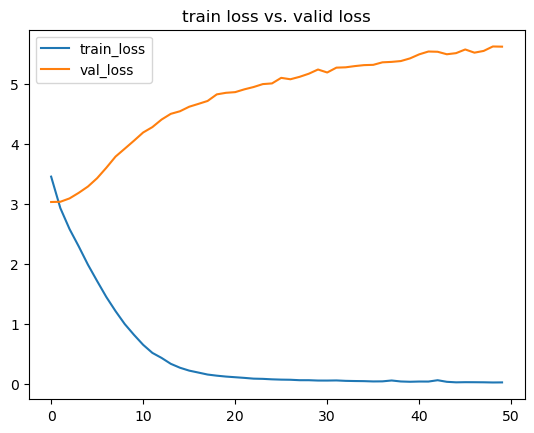

In [42]:
import matplotlib.pyplot as plt

plt.plot(train_list[0], label='train_loss')
plt.plot(val_list[0], label='val_loss')
plt.legend()
plt.title('train loss vs. valid loss')
plt.show()

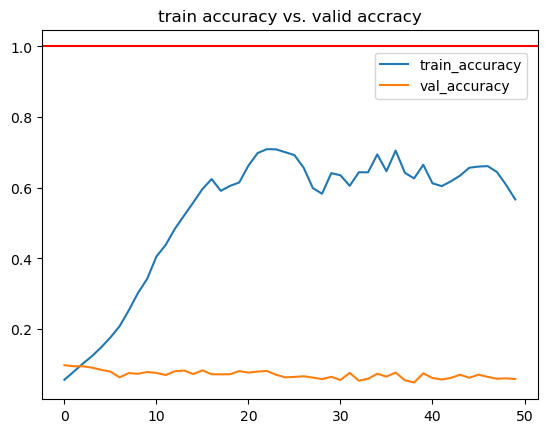

In [59]:
import matplotlib.pyplot as plt

plt.plot(train_list[1], label='train_accuracy')
plt.plot(val_list[1], label='val_accuracy')
plt.axhline(1.0, c='r')
plt.legend(bbox_to_anchor=(0.7, 0.75, 0.25, 0.25), loc='center')
plt.title('train accuracy vs. valid accracy')
plt.show()